In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import time

In [2]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)



**Dataset preparation**

In [3]:
#Loading
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data 

x_train= x_train / 255.0
x_test = x_test / 255.0
 
# One-hot encode labels
num_labels = 10
y_train=one_hot(y_train.astype('int32'),num_labels)
y_test=one_hot(y_test.astype('int32'),num_labels)


x_train = x_train.reshape(60000,28*28)
x_test = x_test.reshape(10000,28*28)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


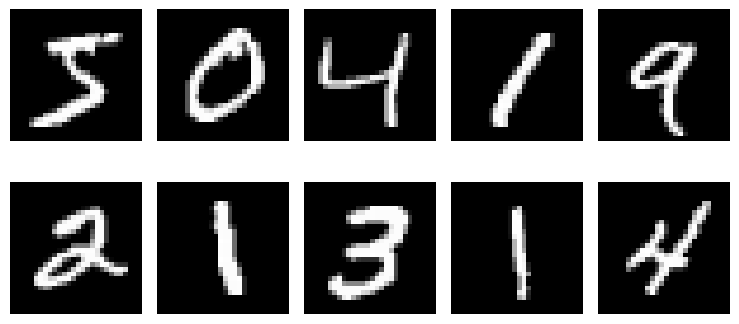

In [4]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

**Initialization**

In [9]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not supported, please use 'relu' or 'sigmoid' instead.")
        
        self.params = self.initialize()
        self.cache = {}

    def relu(self, x, derivative=False):
        ''' ReLU activation function '''
        if derivative:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    def sigmoid(self, x, derivative=False):
        ''' Sigmoid activation function '''
        if derivative:
            return self.sigmoid(x) * (1 - self.sigmoid(x))
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        ''' Softmax activation function '''
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def initialize(self):
        ''' Initialize weights and biases '''
        input_layer = self.sizes[0]
        hidden_layer = self.sizes[1]
        output_layer = self.sizes[2]
        
        params = {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1./input_layer),
            "b1": np.zeros((hidden_layer, 1)) * np.sqrt(1./input_layer),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1./hidden_layer),
            "b2": np.zeros((output_layer, 1)) * np.sqrt(1./hidden_layer)
        }
        return params
    
    def initialize_momentum_optimizer(self):
        ''' Initialize momentum optimizer '''
        momentum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return momentum_opt

    def feed_forward(self, x):
        ''' Forward propagation '''
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]
    
    def back_propagate(self, y, output):
        ''' Backpropagation algorithm '''
        current_batch_size = y.shape[0]
        
        dZ2 = output - y.T
        dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return self.grads

    def l1_regularization(self, lambda_):
        ''' L1 Regularization (Lasso) '''
        l1_loss = 0
        for param in self.params:
            if param.startswith('W'):  # Only apply L1 on weights
                l1_loss += np.sum(np.abs(self.params[param]))
        return lambda_ * l1_loss

    def l2_regularization(self, lambda_):
        ''' L2 Regularization (Ridge) '''
        l2_loss = 0
        for param in self.params:
            if param.startswith('W'):  # Only apply L2 on weights
                l2_loss += np.sum(np.square(self.params[param]))
        return lambda_ * l2_loss

    def cross_entropy_loss(self, y, output, lambda_=0, regularization_type=None):
        ''' Cross entropy loss with optional regularization '''
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        l = -(1./m) * l_sum
        
        # Apply regularization
        if regularization_type == 'l1':
            l += self.l1_regularization(lambda_)
        elif regularization_type == 'l2':
            l += self.l2_regularization(lambda_)
        
        return l

    def optimize(self, l_rate=0.1, beta=.9, lambda_=0, regularization_type=None):
        ''' Stochastic Gradient Descent (SGD) or Momentum optimization '''
        if self.optimizer == "sgd":
            for key in self.params:
                # Add regularization gradient
                if regularization_type == 'l1':
                    self.grads[key] += lambda_ * np.sign(self.params[key])
                elif regularization_type == 'l2':
                    self.grads[key] += lambda_ * self.params[key]
                self.params[key] -= l_rate * self.grads[key]
        elif self.optimizer == "momentum":
            for key in self.params:
                # Add regularization gradient
                if regularization_type == 'l1':
                    self.grads[key] += lambda_ * np.sign(self.params[key])
                elif regularization_type == 'l2':
                    self.grads[key] += lambda_ * self.params[key]
                self.momemtum_opt[key] = (beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] -= l_rate * self.momemtum_opt[key]
        else:
            raise ValueError("Optimizer is currently not supported, please use 'sgd' or 'momentum' instead.")

    def accuracy(self, y, output):
        ''' Calculate accuracy '''
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

    def train(self, x_train, y_train, x_test, y_test, epochs=10, 
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9, 
              lambda_=0, regularization_type=None):
        ''' Training function with regularization '''
        # Hyperparameters
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)
        
        # Initialize optimizer
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momemtum_opt = self.initialize_momentum_optimizer()

        # Lists to store accuracy and loss
        self.train_accuracies = []
        self.train_losses = []
        self.test_accuracies = []
        self.test_losses = []
        
        start_time = time.time()
        template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"
        
        # Train
        for i in range(self.epochs):
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]
                
                output = self.feed_forward(x)
                grad = self.back_propagate(y, output)
                self.optimize(l_rate=l_rate, beta=beta, lambda_=lambda_, regularization_type=regularization_type)

            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output, lambda_=lambda_, regularization_type=regularization_type)
            self.train_accuracies.append(train_acc)
            self.train_losses.append(train_loss)
            
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output, lambda_=lambda_, regularization_type=regularization_type)
            self.test_accuracies.append(test_acc)
            self.test_losses.append(test_loss)
            
            print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss)) 



Epoch 1: 1.29s, train acc=0.86, train loss=1.58, test acc=0.87, test loss=1.55
Epoch 2: 2.61s, train acc=0.85, train loss=1.60, test acc=0.85, test loss=1.59
Epoch 3: 3.95s, train acc=0.85, train loss=1.60, test acc=0.85, test loss=1.58
Epoch 4: 5.26s, train acc=0.84, train loss=1.59, test acc=0.85, test loss=1.57
Epoch 5: 6.68s, train acc=0.86, train loss=1.57, test acc=0.87, test loss=1.56
Epoch 6: 7.98s, train acc=0.85, train loss=1.58, test acc=0.86, test loss=1.56
Epoch 7: 9.31s, train acc=0.87, train loss=1.54, test acc=0.87, test loss=1.52
Epoch 8: 10.63s, train acc=0.85, train loss=1.56, test acc=0.86, test loss=1.54
Epoch 9: 11.94s, train acc=0.86, train loss=1.57, test acc=0.86, test loss=1.55
Epoch 10: 13.26s, train acc=0.85, train loss=1.58, test acc=0.86, test loss=1.56
Epoch 1: 1.40s, train acc=0.10, train loss=5.12, test acc=0.10, test loss=5.13
Epoch 2: 2.93s, train acc=0.10, train loss=4.87, test acc=0.10, test loss=4.88
Epoch 3: 4.33s, train acc=0.10, train loss=4.87,

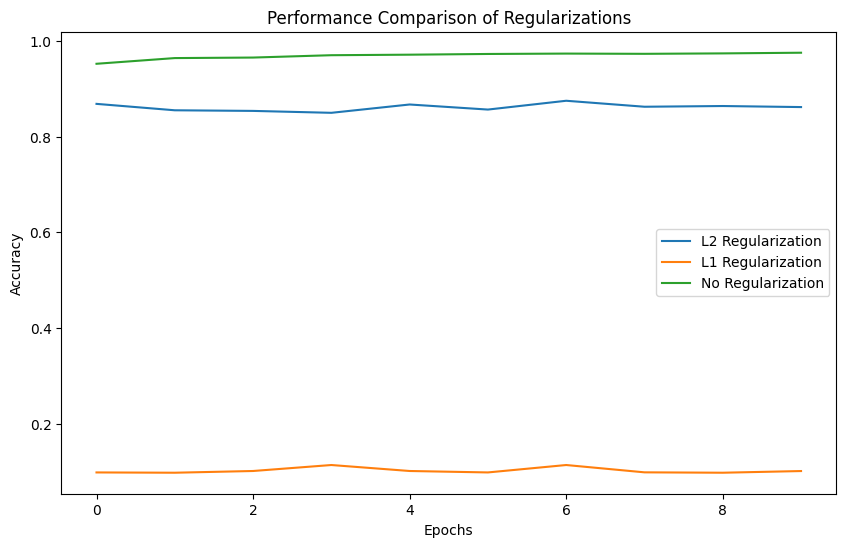

In [10]:
# Sigmoid + Momentum with L2 Regularization
dnn_l2 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn_l2.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=4, lambda_=0.01, regularization_type='l2')

# Sigmoid + Momentum with L1 Regularization
dnn_l1 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn_l1.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=4, lambda_=0.01, regularization_type='l1')

# Sigmoid + Momentum without Regularization
dnn_no_reg = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn_no_reg.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=4)

# Plot results
plt.figure(figsize=(10,6))

plt.plot(range(dnn_l2.epochs), dnn_l2.test_accuracies, label='L2 Regularization')
plt.plot(range(dnn_l1.epochs), dnn_l1.test_accuracies, label='L1 Regularization')
plt.plot(range(dnn_no_reg.epochs), dnn_no_reg.test_accuracies, label='No Regularization')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Performance Comparison of Regularizations')
plt.show()